In [73]:
import os
import sys
import time
import numpy as np
import fitsio
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import vaex as vx
%matplotlib inline

# Validation plots for sextractor geometrical quantities: a, b, theta

In [2]:
def get_all(pattern, columns=None):
    if (not isinstance(columns, list)):
        print("If no list of keys is input, then all are retrieved")
    tabls = []
    counter = True
    t0 = time.time()
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for idx, f in enumerate(filenm):
            if (pattern in f):
                tabls.append(f)
                hdu = fitsio.FITS(f)
                if counter:
                    if (columns is None):
                        r_arr = hdu[1].read()
                    else:
                        r_arr = hdu[1].read()[columns]
                    counter = False
                else:
                    if (columns is None):
                        r_arr = np.concatenate((r_arr, hdu[1].read()))
                    else:
                        r_arr = np.concatenate((r_arr, hdu[1].read()[columns]))
                hdu.close()
                print("{0} loaded".format(f))
    print("Elapsed time in reading the FITS: {0:.2f} min".format((time.time() - t0) / 60.))
    return r_arr

## Read the data for the entire sample

In [3]:
# Read the A, B, and THETA info
abt = get_all("DR1_MAIN_ABTHETA_")
# Sort it
idx_abt = np.argsort(abt["COADD_OBJECT_ID"])
abt = abt[idx_abt]

If no list of keys is input, then all are retrieved
DR1_MAIN_ABTHETA_000001.fits loaded
DR1_MAIN_ABTHETA_000002.fits loaded
DR1_MAIN_ABTHETA_000003.fits loaded
DR1_MAIN_ABTHETA_000004.fits loaded
DR1_MAIN_ABTHETA_000005.fits loaded
DR1_MAIN_ABTHETA_000006.fits loaded
DR1_MAIN_ABTHETA_000007.fits loaded
Elapsed time in reading the FITS: 1.20 min


In [4]:
# Read the Star/Galaxy separation table: ('COADD_OBJECT_ID', 'EXT_WAVG', 'EXT_COADD')
sg = get_all("BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_")
# Sort it by WAVG classif
idx_sg = np.argsort(sg["EXT_WAVG"])
sg = sg[idx_sg]

If no list of keys is input, then all are retrieved
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000001.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000002.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000003.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000004.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000005.fits loaded
Elapsed time in reading the FITS: 0.58 min


In [5]:
print("Percentage of the total sample: {0}%".format(round(abt.shape[0]/4.e8 * 100.)))

Percentage of the total sample: 57%


In [6]:
# Split COADD_OBJ_ID in groups, using the WAVG classificator
# aux_sg = [sg[np.where(sg["EXT_WAVG"] == x)]["COADD_OBJECT_ID"] for x in [0, 1, 2, 3]]
idx_sg = [np.where(sg["EXT_WAVG"] == x) for x in [0, 1, 2, 3]]

In [7]:
# Apply the indices of each group to the main array, creating as many sub arrays as class groups. 
# group_sg = [sg[y] for y in idx_sg]
t0 = time.time()
group_sg = []
for g in idx_sg:
    tmp = sg[g]
    tmp_idx = np.argsort(tmp["COADD_OBJECT_ID"])
    group_sg.append(tmp[tmp_idx])
t1 = time.time()
print("Grouped and sorted in {0:.2f} min".format((t1 - t0)/60.))

Grouped and sorted in 2.02 min


### Crossmatch the IDs from the group classifications against the table value. When comparing the performance of np.where(np.in1d()) against recf.join_by(), the first was faster

In [13]:
# Using the objects IDs, get the indices of each of the s/g classes
xm_sg_idx = [np.where(np.in1d(abt["COADD_OBJECT_ID"], sgroup["COADD_OBJECT_ID"])) for sgroup in group_sg]
print("xmatch was successful")

xmatch was successful


In [14]:
print("Columns and its data types: \n\t{0} \n\t{1}".format(abt.dtype, sg.dtype))

Columns and its data types: 
	[('A_IMAGE', '>f8'), ('B_IMAGE', '>f8'), ('THETA_J2000', '>f8'), ('COADD_OBJECT_ID', '>i8')] 
	[('COADD_OBJECT_ID', '>i8'), ('EXT_WAVG', '>i2'), ('EXT_COADD', '>i2')]


### Backup in case of need

In [17]:
pickle.dump(xm_sg_idx, open("xm_sg_idx.pickle", "wb"))

In [ ]:
xm_sg_idx = pickle.load(open("xm_sg_idx.pickle", "rb"))

### abt was not pickle-d because the larger size pickle can manage is 4 GiB

## Import to vaex

### Star classes

In [19]:
# Using each one of the classes separately, do the A, B, THETA distributions
# Note: a better way is to use 'selection' under vaex 
# Import into vaex
# Data for star classifications
ds0 = vx.from_arrays(A=abt[xm_sg_idx[0]]["A_IMAGE"], 
                     B=abt[xm_sg_idx[0]]["B_IMAGE"], 
                     BA=abt[xm_sg_idx[0]]["B_IMAGE"]/abt[xm_sg_idx[0]]["A_IMAGE"],
                     T=abt[xm_sg_idx[0]]["THETA_J2000"]
                    )
ds1 = vx.from_arrays(A=abt[xm_sg_idx[1]]["A_IMAGE"], 
                     B=abt[xm_sg_idx[1]]["B_IMAGE"], 
                     BA=abt[xm_sg_idx[1]]["B_IMAGE"]/abt[xm_sg_idx[1]]["A_IMAGE"],
                     T=abt[xm_sg_idx[1]]["THETA_J2000"]
                    )

### Galaxy classes

In [20]:
# Data for galaxy classifications
ds2 = vx.from_arrays(A=abt[xm_sg_idx[2]]["A_IMAGE"], 
                     B=abt[xm_sg_idx[2]]["B_IMAGE"], 
                     BA=abt[xm_sg_idx[2]]["B_IMAGE"]/abt[xm_sg_idx[2]]["A_IMAGE"],
                     T=abt[xm_sg_idx[2]]["THETA_J2000"]
                    )
ds3 = vx.from_arrays(A=abt[xm_sg_idx[3]]["A_IMAGE"], 
                     B=abt[xm_sg_idx[3]]["B_IMAGE"],
                     BA=abt[xm_sg_idx[3]]["B_IMAGE"]/abt[xm_sg_idx[3]]["A_IMAGE"],
                     T=abt[xm_sg_idx[3]]["THETA_J2000"]
                    )

### Plotting b/a distribution, while closer to 1 then e~0

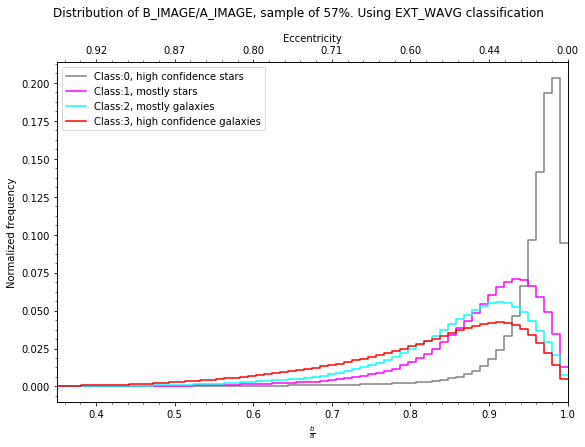

In [74]:
plt.close("all")
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twiny()

# Make the plot
# VERY important to set limits here, this way they match them overlaping axis
lim = [0.35, 1.]
kw = {
    "what": "count(*)",
    "n": "normalize",
    "limits":lim,
}
a = ds0.plot1d("BA", color="gray", label="Class:0, high confidence stars", **kw)
a = ds1.plot1d("BA", color="magenta", label="Class:1, mostly stars", **kw)
a = ds2.plot1d("BA", color="cyan", label="Class:2, mostly galaxies", **kw)
a = ds3.plot1d("BA", color="red", label="Class:3, high confidence galaxies", **kw)
plt.legend(loc="upper left", fancybox=True)

# Initial plot setup
ax1.set_xlim(lim)
ax1.set_xlabel(r"$\frac{b}{a}$")
ax1.set_ylabel("Normalized frequency")

# Setup tics
new_tick_locations = np.array([.4, .5, .6, .7, .8, .9, 1.])
def tick_function(x):
    res = np.sqrt(1 - np.power(x, 2))
    return ["%.2f" % z for z in res]

# Set the limits based on initial plot
# ax2.set_xlim(ax1.get_xlim())
ax2.set_xlim(lim) # plt.xlim())

#  Values and tics
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Eccentricity")

# Add minor tics
# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax1.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()
ax1.yaxis.set_minor_locator(minorLocator_y)
# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax2.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()

plt.suptitle(r"Distribution of B_IMAGE/A_IMAGE, sample of {0}%. Using EXT_WAVG classification".format(round(abt.shape[0]/4.e8 * 100.)))
plt.subplots_adjust(top=0.85, left=0.2)
plt.savefig("ba_subsample.png", format="png", dpi=500)

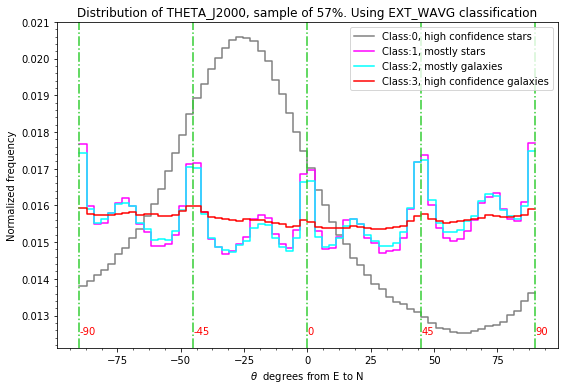

In [93]:
# Theta distribution
plt.close("all")
fig, ax1 = plt.subplots(figsize=(8,6))

# Make the plot
lim = [-90, 90]
kw = {
    "what": "count(*)",
    "n": "normalize",
    "limits":lim,
}
a = ds0.plot1d("T", color="gray", label="Class:0, high confidence stars", **kw)
a = ds1.plot1d("T", color="magenta", label="Class:1, mostly stars", **kw)
a = ds2.plot1d("T", color="cyan", label="Class:2, mostly galaxies", **kw)
a = ds3.plot1d("T", color="red", label="Class:3, high confidence galaxies", **kw)
plt.legend(loc="upper right", fancybox=True)

# Add vertical lines on 45 deg and in others
for i in [-90, -45, 0, 45, 90]:
    ax1.axvline(x=i, color="limegreen", linestyle="-.")
    ax1.text(i, 0.0125, "{0}".format(i), color="red")

# Add minor tics
# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax1.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()
ax1.yaxis.set_minor_locator(minorLocator_y)

plt.xlabel(r"$\theta$  degrees from E to N")
plt.ylabel("Normalized frequency")
plt.title(r"Distribution of THETA_J2000, sample of {0}%. Using EXT_WAVG classification".format(round(abt.shape[0]/4.e8 * 100.)))
plt.subplots_adjust(top=0.85)
plt.savefig("theta_subsample.png", format="png", dpi=500)